# BLG407 – Makine Öğrenmesi Proje Ödevi  
## Model 1 – Transfer Learning (VGG16)

**Adı:** İbrahim Çerkezoğlu  
**Okul Numarası:** 2112721046  
**Ders:** BLG407 – Makine Öğrenmesi  
**Ödev Konusu:** Kendi görüntü verisetimle CNN sınıflandırma modeli geliştirme  
**GitHub Repo Bağlantısı:** https://github.com/ibrahimcerkezoglu/CNN_siniflandirma

Bu notebook, proje kapsamında kullanılan **Model 1 (Transfer Learning)** çalışmasını içermektedir.  
Bu modelde, ImageNet üzerinde önceden eğitilmiş **VGG16** mimarisi taban alınmış ve kendi çektiğim
“bardak” ve “şişe” görüntüleri üzerinde ince ayar (fine-tuning olmadan, sadece üst katman eğitimi) yapılmıştır.


### 1. Kurulum ve temel parametreler

Bu bölümde TensorFlow/Keras kütüphaneleri import edilmekte, veri klasör yolları tanımlanmakta ve
giriş görüntü boyutu ile `batch_size` / `epochs` gibi temel hiperparametreler belirlenmektedir.


In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import os

print("TensorFlow sürümü:", tf.__version__)

# Klasör yolları
base_dir = r"C:\Users\ibrah\Documents\BLG407_Proje\dataset"
train_dir = os.path.join(base_dir, "train")
test_dir  = os.path.join(base_dir, "test")

img_size = (128, 128)
batch_size = 16
epochs = 10


TensorFlow sürümü: 2.10.0


### 2. Veri setinin hazırlanması

Veri seti, **bardak** ve **şişe** olmak üzere iki sınıftan oluşmaktadır.  
Tüm görüntüler tarafımdan telefon kamerası ile çekilmiş ve aşağıdaki klasör yapısında organize edilmiştir:

`dataset/train/bardak`, `dataset/train/sise`, `dataset/test/bardak`, `dataset/test/sise`.

Bu hücrede Keras `ImageDataGenerator` ile sadece **ölçekleme (rescale=1./255)** uygulanmış,
herhangi bir veri artırımı yapılmamıştır. Bu, Model 1’i saf transfer learning olarak tutmak içindir.


In [3]:
# ---- 2) Data generator'lar ----
train_gen = ImageDataGenerator(rescale=1./255)
test_gen  = ImageDataGenerator(rescale=1./255)

train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",   # 2 sınıf
    shuffle=True
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode="binary",
    shuffle=False
)

print("Sınıf indeksleri:", train_data.class_indices)


Found 126 images belonging to 2 classes.
Found 32 images belonging to 2 classes.
Sınıf indeksleri: {'bardak': 0, 'sise': 1}


### 3. Model 1 – VGG16 ile Transfer Learning

Bu modelde **VGG16** mimarisinin `include_top=False` seçeneğiyle **konvolüsyonel tabanı** kullanılmış,
ImageNet üzerinde öğrenilmiş ağırlıklar dondurulmuştur (`trainable = False`).

Üstüne:
- Global özellikleri çıkaran bir `Flatten` katmanı,
- 128 nöronlu bir `Dense + ReLU` katmanı,
- Aşırı öğrenmeyi azaltmak için `Dropout(0.3)`,
- Çıkışta ikili sınıflandırma için `sigmoid` aktivasyonlu `Dense(1)` katmanı eklenmiştir.

Optimizasyon için **Adam** kullanılmış ve kayıp fonksiyonu **binary crossentropy** olarak seçilmiştir.


In [4]:
# ---- 3) VGG16 tabanlı Transfer Learning modeli ----
base_model = VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(img_size[0], img_size[1], 3)
)

# Önceden öğrenilmiş katmanları dondur
base_model.trainable = False

x = Flatten()(base_model.output)
x = Dense(128, activation="relu")(x)
x = Dropout(0.3)(x)
output = Dense(1, activation="sigmoid")(x)   # binary sınıflandırma

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()

# ---- 4) Modeli eğit ----
history = model.fit(
    train_data,
    epochs=epochs,
    validation_data=test_data
)


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

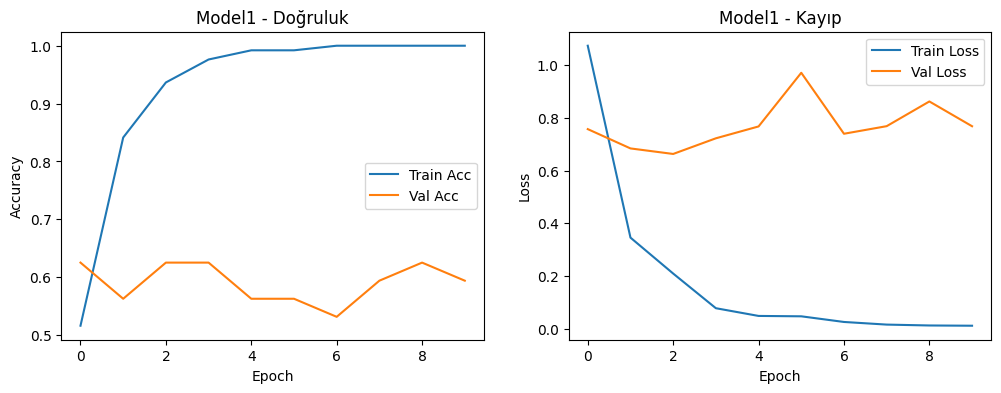

2/2 [==============================] - 1s 254ms/step - loss: 0.7684 - accuracy: 0.5938
Model1 - Test kaybı: 0.7684
Model1 - Test doğruluğu: 0.5938


In [5]:
# ---- 5) Eğitim grafikleri ----
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train Acc")
plt.plot(history.history["val_accuracy"], label="Val Acc")
plt.title("Model1 - Doğruluk")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Model1 - Kayıp")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.show()

# ---- 6) Test doğruluğu ----
test_loss, test_acc = model.evaluate(test_data)
print(f"Model1 - Test kaybı: {test_loss:.4f}")
print(f"Model1 - Test doğruluğu: {test_acc:.4f}")


### 4. Model 1 – Sonuçların Değerlendirilmesi

Eğitim sürecinde gözlenenler:

- Eğitim doğruluğu ilk epoch'ta yaklaşık **%52** civarından başlayıp birkaç epoch içinde **%100** seviyesine kadar çıkmıştır.
- Doğrulama (validation) doğruluğu ise **%56–%63** aralığında dalgalanmış ve son epoch'ta **%59.38** seviyesinde kalmıştır.
- Eğitim kaybı (train loss) 1. epoch'tan itibaren hızlı bir şekilde düşerek **0.01** civarına kadar inmiştir.
- Doğrulama kaybı (val loss) ise ilk epoch'tan sonra belirgin bir şekilde dalgalanmış ve eğitim kaybına göre oldukça yüksek kalmıştır.

Test seti değerlendirme sonuçları:

- **Model1 - Test kaybı:** `0.7684`
- **Model1 - Test doğruluğu:** `0.5938` (≈ **%59.38**)

Bu davranış, Model 1’in eğitim verisine çok iyi uyum sağladığını ancak küçük veri seti ve dağılım farkı nedeniyle
**aşırı öğrenme (overfitting)** yaşadığını göstermektedir. VGG16 tabanının ImageNet üzerinde öğrenilmiş güçlü
özellikleri, 126 örnekli küçük veri setimde eğitimi çok hızlı bir şekilde ezberlemiştir; ancak bu ezberleme,
test verisine genelleme yaparken yeterince başarılı olamamıştır.

Transfer learning’in avantajı, derin bir ağın daha önce öğrendiği **kenar, doku, şekil** gibi genel görsel özellikleri
yeniden kullanabilmesidir. Buna karşılık bu projede:

- Veri setim iki sınıftan (bardak / şişe) oluşan **küçük ve basit bir veri setidir**,
- Görüntüler, ImageNet’teki geniş ve çeşitli doğal görüntülere göre **daha dar bir dağılıma** sahiptir.

Bu nedenle, VGG16 tabanlı Model 1’in eğitimi hızlı ve başarılı görünse de, test performansı sınırlı kalmış
ve bir sonraki adımda sıfırdan tasarlanan basit CNN (Model 2) ile karşılaştırıldığında **genelleme açısından dezavantajlı**
bir model olmuştur.
